In [55]:
# import all packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from keras import regularizers
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [56]:
### original dataset visualization

def show_orgi_data(dataset_name):
    
    # load data
    data = pd.read_csv(dataset_name, header=0, parse_dates=[0], index_col=0, squeeze=True)
    
    # show original data
    groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    i = 1
    # plot each column
    plt.figure(figsize=(15,20))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(data.values[:, group])
        plt.title(data.columns[group], y=0.5, loc='right')
        i += 1
    plt.tight_layout()
    data.info()
    
    return data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

,date,Fossil hard coal[MWh],Fossil brown coal[MWh],Fossil gas[MWh],Biomass[MWh],NO2-2019,NO2-2020,covid-policy-stringency-index,COVID-19 increased cases,COVID-19 increased deaths,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-01-01,47429,246640,115606,116645,13.3000,28.7200,0.0,0,0,0.0
1,2020-01-02,59265,253314,132797,116189,13.9975,32.0650,0.0,0,0,0.0
2,2020-01-03,71263,183767,109478,116636,24.6250,16.5050,0.0,0,0,0.0
3,2020-01-04,71545,173147,104930,117117,19.5150,11.7550,0.0,0,0,0.0
4,2020-01-05,60369,254708,137009,115969,14.9550,22.0675,0.0,0,0,0.0


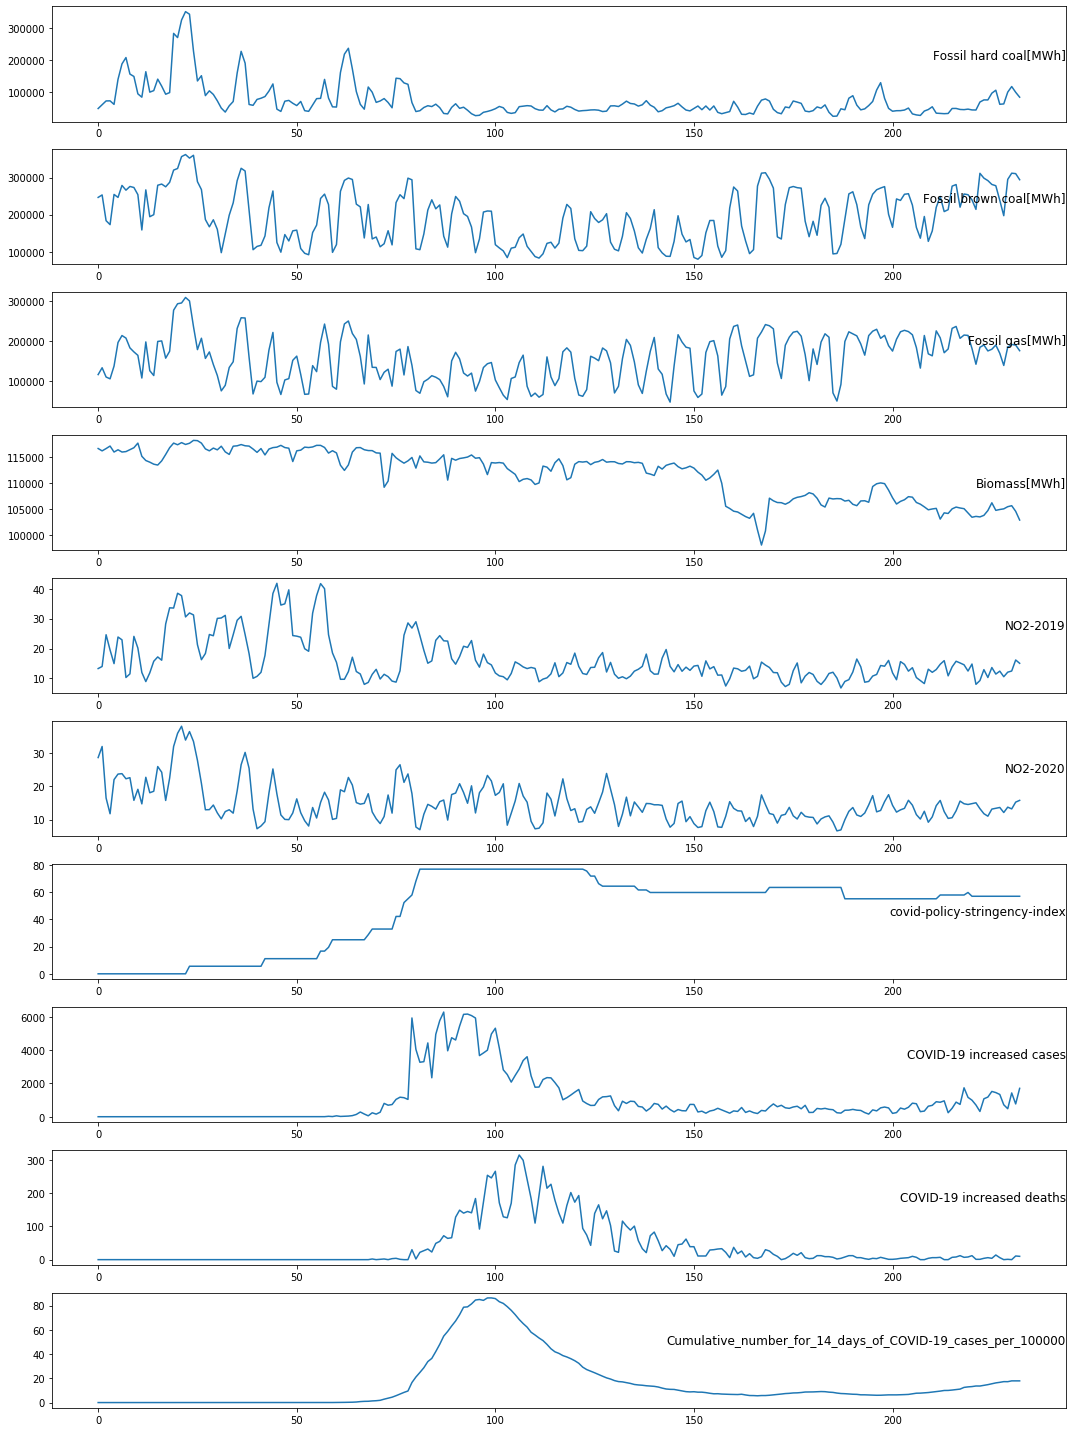

In [57]:
dataset_name='AMI_Data.csv'
data = show_orgi_data(dataset_name)
data.head()

In [85]:
### data pre-processing

def pre_processing(data):
    # check nonnull
    data = data.fillna(data.mean())
    
    # split the data to end up with the following dataframes: X_train,X_test,y_train, y_test   
    data['NO2_reduction'] = data['NO2-2019'] - data['NO2-2020']
    X = data.drop(columns=['date','NO2-2019','NO2-2020','NO2_reduction','COVID-19 increased cases','COVID-19 increased deaths','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    y = data['NO2_reduction']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)
    
    # standardscaler
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train_scaled = xscaler.fit_transform(X_train)
    X_test_scaled = xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_scaled = yscaler.transform(y_test.values.reshape(-1,1))
    
    # perform a boxplot of X_train_scaled here
    ax = sns.boxplot(data=X_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("original data distribution")
    plt.show()
    
    ax = sns.boxplot(data=X_train_scaled)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("pre_processing data distribution")
    plt.show()
   
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, yscaler

In [80]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [60]:
### plot learning curve
def plot_learning_curves(model, X_train, X_test, y_train, y_test):    
    train_errors, test_errors = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    plt.show()

In [61]:
### plot observed data and predicted data
def plot_residual(model, X_train, X_test, y_train, y_test, yscaler):
    
    #get_ipython().run_line_magic('matplotlib', 'inline')
    
#     st.markdown("## Observed Data and Predicted Data")
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    y_test = yscaler.inverse_transform(y_test)
    y_pred_test = yscaler.inverse_transform(y_pred_test)
    
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
#     st.pyplot()
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()
#     st.pyplot()

In [62]:
### plot observed data and predicted data for NNs model
def plot_residual_nns(model, X_train, X_test, y_train, y_test, yscaler):
    y_pred_train = np.concatenate(model.predict(X_train).astype('float'))
    y_pred_test = np.concatenate(model.predict(X_test).astype('float'))

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    y_test = yscaler.inverse_transform(y_test)
    y_pred_test = yscaler.inverse_transform(y_pred_test)
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test.reshape(-1,1),y=y_pred_test.reshape(-1,1), height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()

In [63]:
### Model 1: Decision Trees
# with best parameters
def dt_model(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.compose import TransformedTargetRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline

    sc = StandardScaler()
    dtr = DecisionTreeRegressor(splitter='best',random_state=42,min_samples_split=5,max_features=6,criterion='mse')
    pipe = Pipeline([('scaler',sc),('tree', dtr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())   
    model.fit(X_train, y_train)
    return model
#     plot_residual(model,X_train, X_test, y_train, y_test)
#     plot_learning_curves(model, X_train, X_test, y_train, y_test)


In [64]:
### Model 2: random forests

def rf_model(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.compose import TransformedTargetRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline    

    sc = StandardScaler()
    rfr = RandomForestRegressor(n_estimators=500,max_features=5)
    pipe = Pipeline([('scaler',sc),('forest', rfr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model
#     plot_residual(model,X_train, X_test, y_train, y_test)
#     plot_learning_curves(model, X_train, X_test, y_train, y_test)

In [65]:
### Model 3: adaboost
def ab_model(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.compose import TransformedTargetRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline 
    
    sc = StandardScaler()
    dtr = DecisionTreeRegressor(splitter='best',random_state=42)
    pipe = AdaBoostRegressor(base_estimator = dtr,n_estimators=1000)
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model
#     plot_residual(model,X_train, X_test, y_train, y_test)
#     plot_learning_curves(model, X_train, X_test, y_train, y_test)

In [66]:
### Model 4: gbt
def gbt_model(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.compose import TransformedTargetRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline 
    import pickle
    
    sc = StandardScaler()
    gbt = GradientBoostingRegressor(n_estimators=1000,max_features=5)
    pipe = Pipeline([('scaler',sc),('gbt', gbt)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model
#     clf_gbt_2 = pickle.load(open('decision_gbt_model_2.pkl', 'rb'))
#     plot_residual(clf_gbt_2,X_train, X_test, y_train, y_test)
#     plot_residual(model,X_train, X_test, y_train, y_test)
#     plot_learning_curves(model, X_train, X_test, y_train, y_test)

In [67]:
### Model 5: SVM
def svm_model(X_train, X_test, y_train, y_test):

    svm_poly_reg = SVR(kernel="poly", degree=3, C=1, epsilon=0.1, gamma= 0.5, verbose = 2)
    svm_poly_reg.fit(X_train, y_train)
    return svm_poly_reg
#     plot_learning_curves(model, X_train, X_test, y_train, y_test)
#     plot_residual(svm_poly_reg, X_train, X_test, y_train, y_test)

In [68]:
### Model 6: KNN
def knn_model(X_train, X_test, y_train, y_test):
    neigh = KNeighborsRegressor(n_neighbors=10)
    neigh.fit(X_train, y_train)
    return neigh
#     plot_residual(neigh, X_train, X_test, y_train, y_test)
   

In [69]:
### Model 7: GPR
def gp_model(X_train, X_test, y_train, y_test):

    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel,
       random_state=42).fit(X_train, y_train)
    return gpr
#     plot_residual(gpr, X_train, X_test, y_train, y_test)

In [70]:
### Model 8: NNs
def nns_model(X_train, X_test, y_train, y_test, epochs = 20, batch_size = 256):
    from sklearn.model_selection import train_test_split
    from keras import regularizers
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras import metrics
    from keras.callbacks import EarlyStopping
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation="linear", name="output"))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.MeanSquaredError()])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    history_nns = model.fit(X_train, y_train, validation_split=0.25, epochs=epochs, callbacks=[es], verbose=0)

#     plot_learning_curves(model, X_train, X_test, y_train, y_test)
#     plot_residual_nns(model, X_train, X_test, y_train, y_test)
    plot_model_history(history_nns, plttitle='NNs')
    return model

In [82]:
### complete pipeline

def main(dataset_name,model_name):
    ### Pipeline: 1. show original data
    data = show_orgi_data(dataset_name)
    
    ### Pipeline: 2. data pre-processing
    X_train, X_test, y_train, y_test, yscaler = pre_processing(data)
    
    start = time.time()
    ### Pipeline: 3. model selection
    if model_name == 'Decision Tree':
#         st.markdown("# Pipeline: 3. Choose model 'Decision Tree' ")
        model = dt_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Random Forests':
#         st.markdown("# Pipeline: 3. Choose model 'Random Forests' ")
        model = rf_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Adaboost':
#         st.markdown("# Pipeline: 3. Choose model 'Adaboost' ")
        model = ab_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'GBDT':
#         st.markdown("# Pipeline: 3. Choose model 'GBDT' ")
        model = gbt_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'SVM':
#         st.markdown("# Pipeline: 3. Choose model 'SVR' ")
        model = svm_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Gaussian Process':
#         st.markdown("# Pipeline: 3. Choose model 'Gaussian Process' ")
        model = gp_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'KNN':
#         st.markdown("# Pipeline: 3. Choose model 'KNN' ")
        model = knn_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Neural Network':
#         st.markdown("# Pipeline: 3. Choose model 'Neural Network' ")
        model = nns_model(X_train, X_test, y_train, y_test)
        plot_residual_nns(model, X_train, X_test, y_train, y_test, yscaler)
    
    training_times = time.time()-start
    print(training_times)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

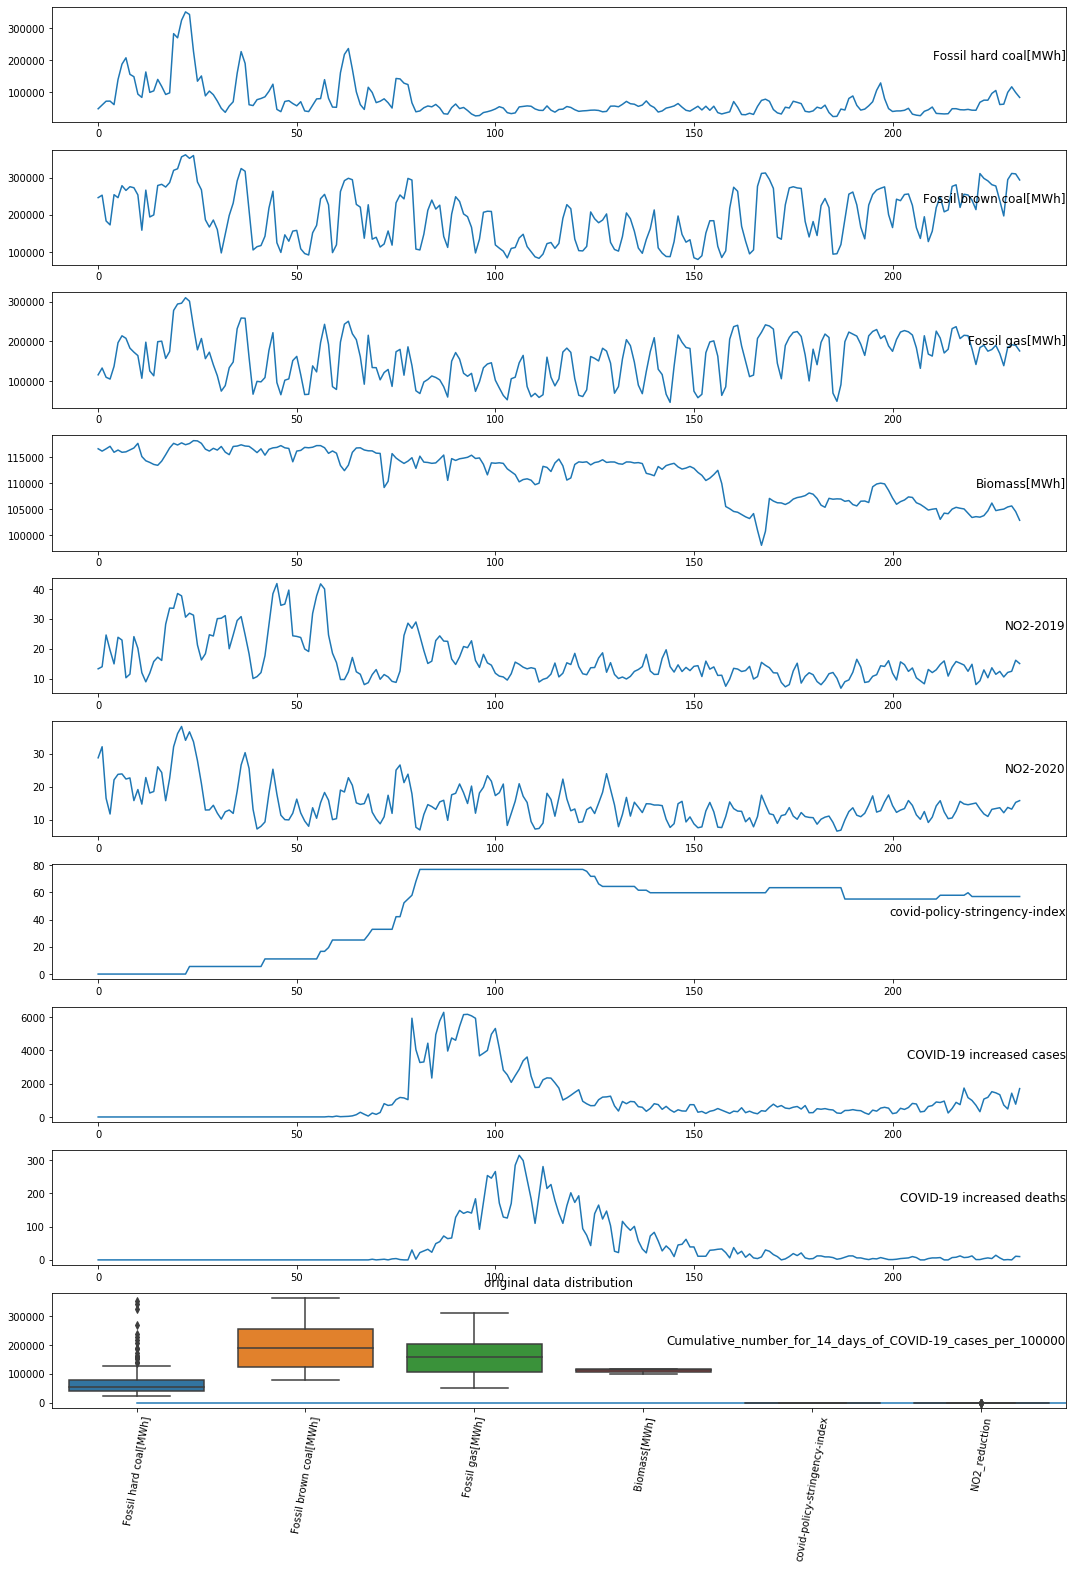

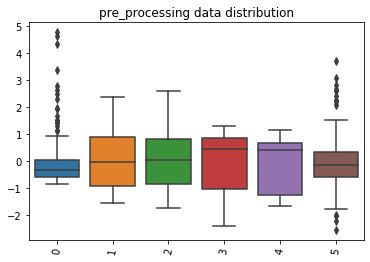

RMSE training fit: 0.060
R2 training fit: 0.996 
RMSE prediction: 0.069
R2 prediction: 0.995 


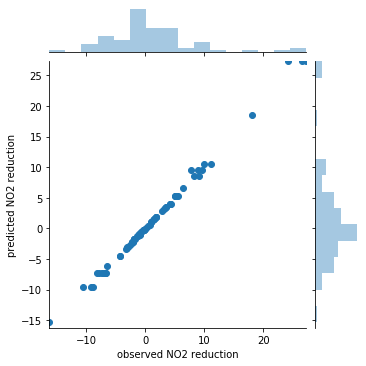

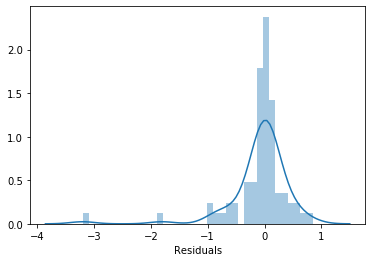

1.4611778259277344


In [74]:
dataset_name = 'AMI_Data.csv'
model_name = 'Decision Tree'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

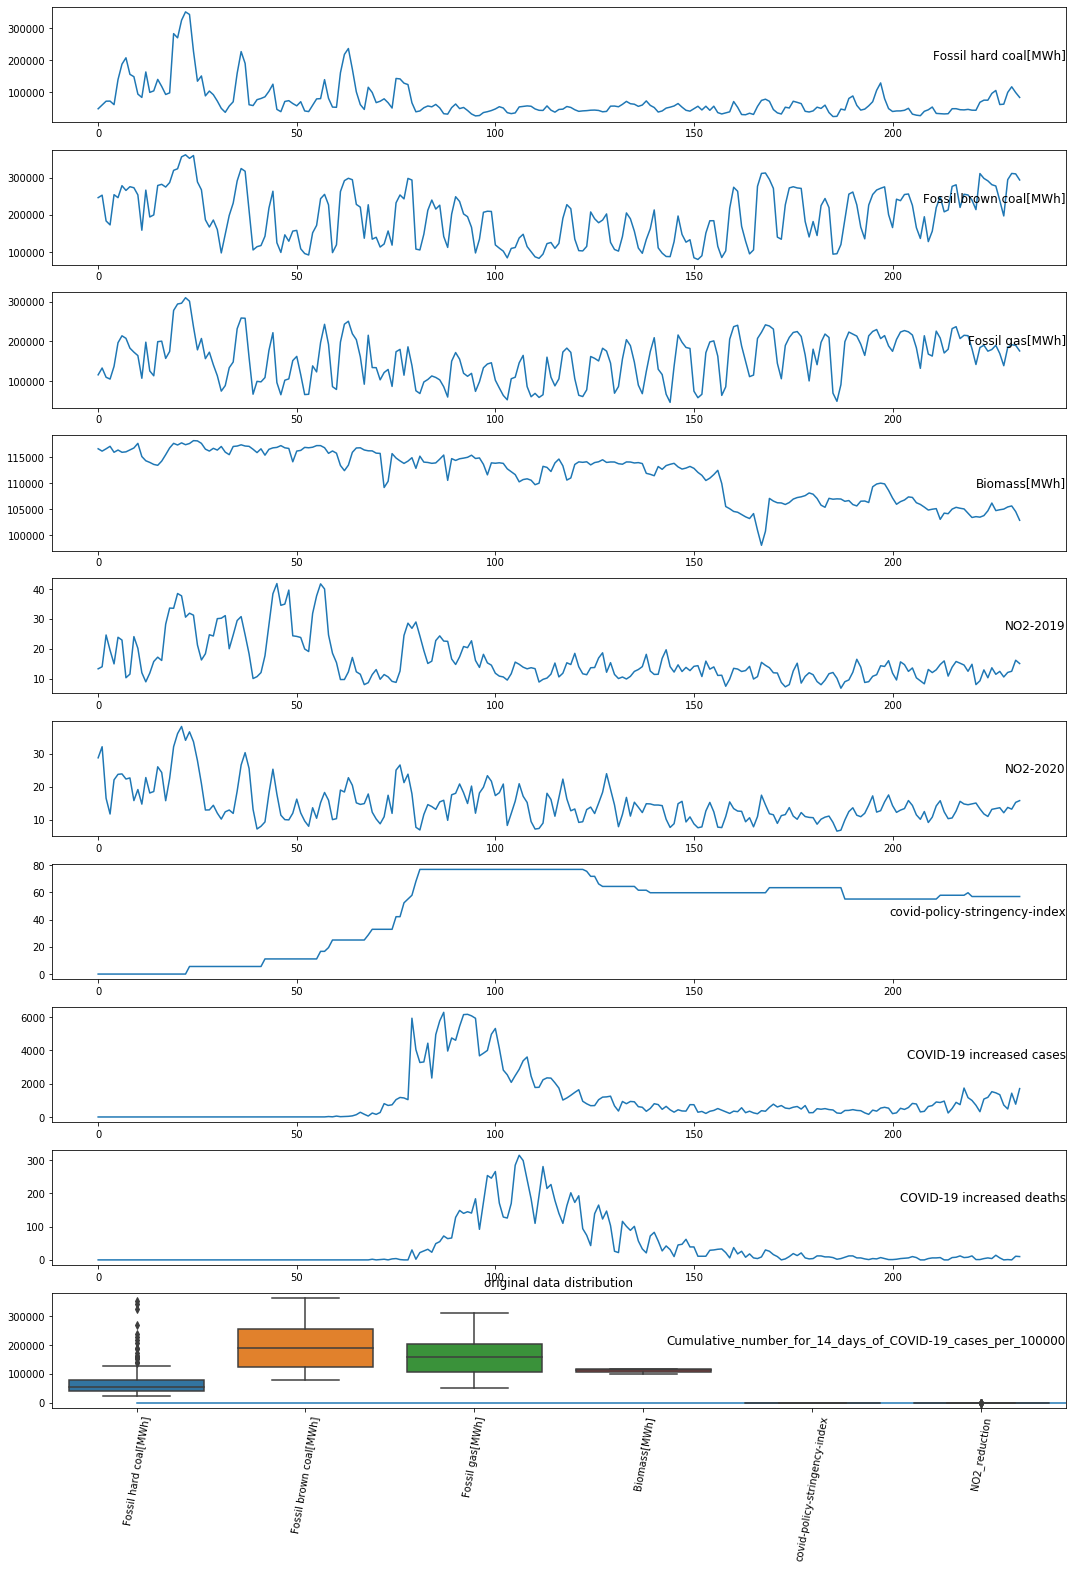

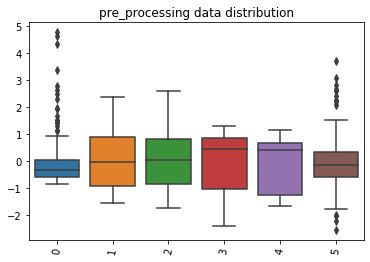

RMSE training fit: 0.042
R2 training fit: 0.998 
RMSE prediction: 0.071
R2 prediction: 0.995 


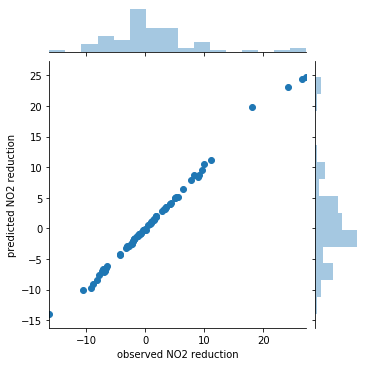

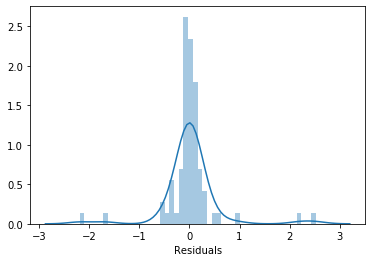

3.3747880458831787


In [75]:
dataset_name = 'AMI_Data.csv'
model_name = 'Random Forests'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

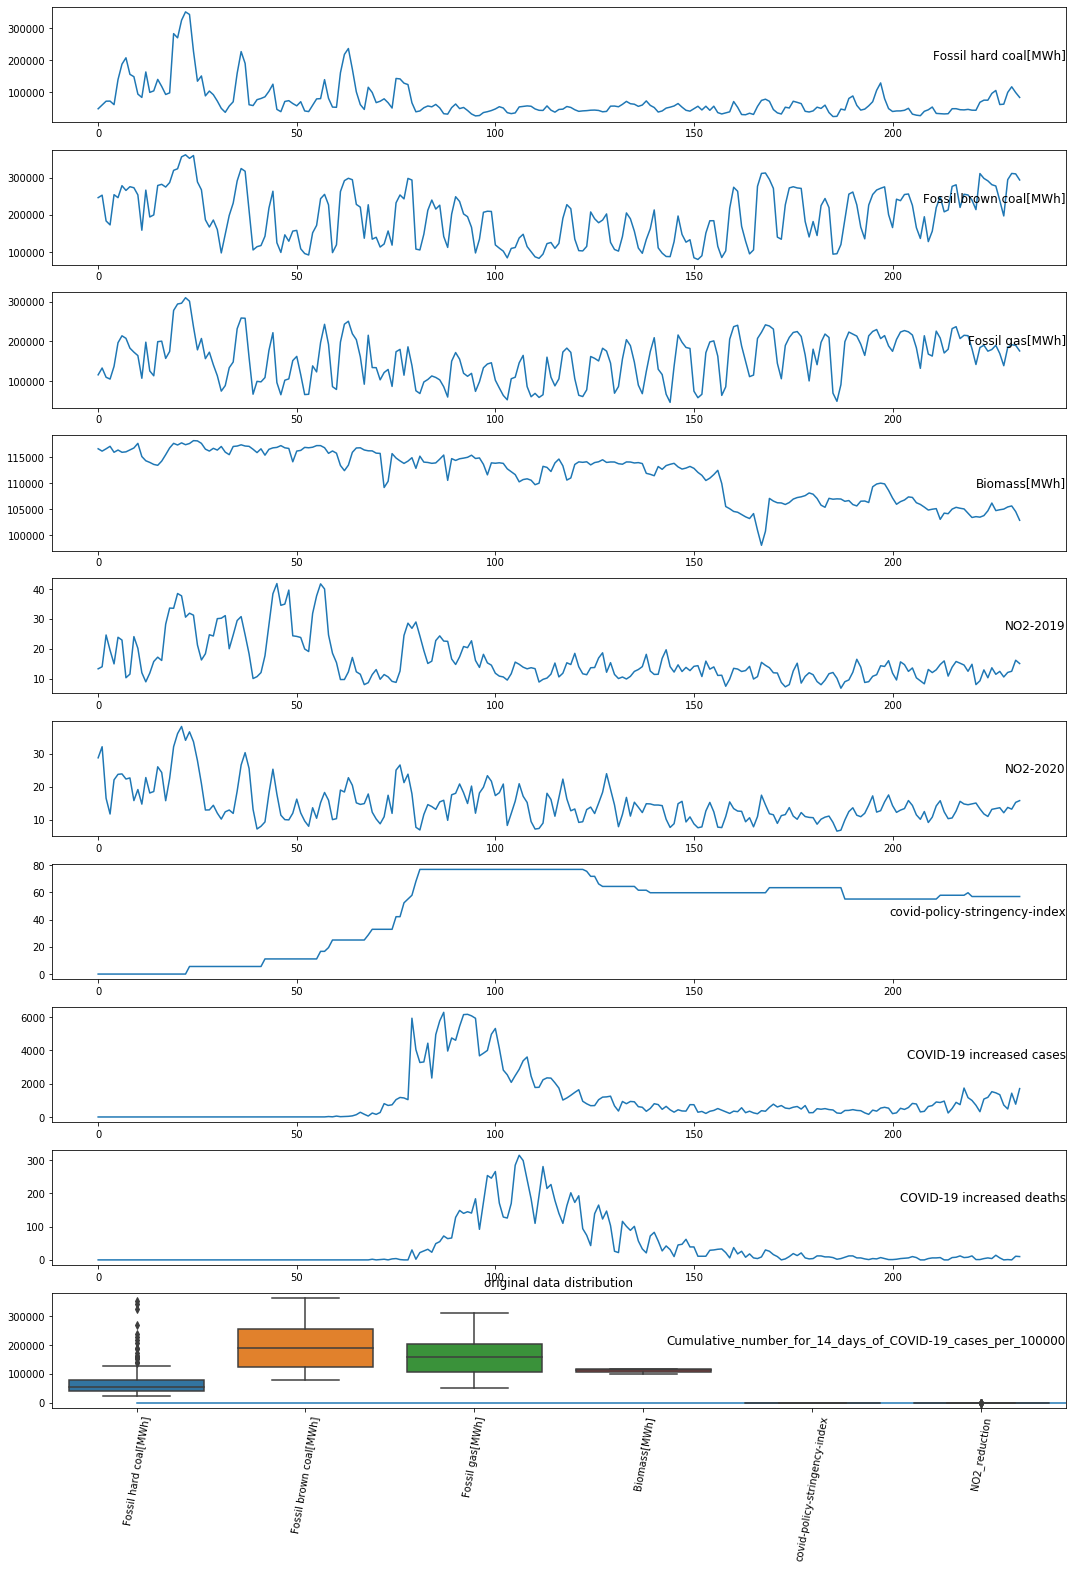

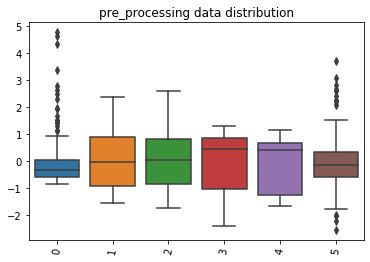

RMSE training fit: 0.003
R2 training fit: 1.000 
RMSE prediction: 0.060
R2 prediction: 0.996 


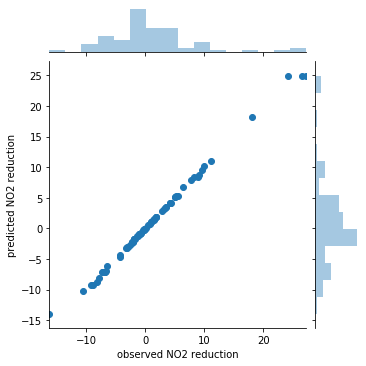

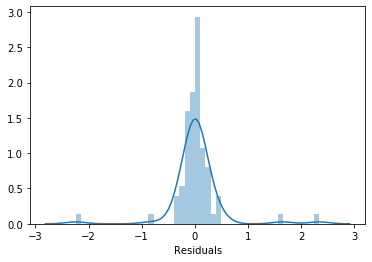

5.6390461921691895


In [76]:
dataset_name = 'AMI_Data.csv'
model_name = 'Adaboost'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

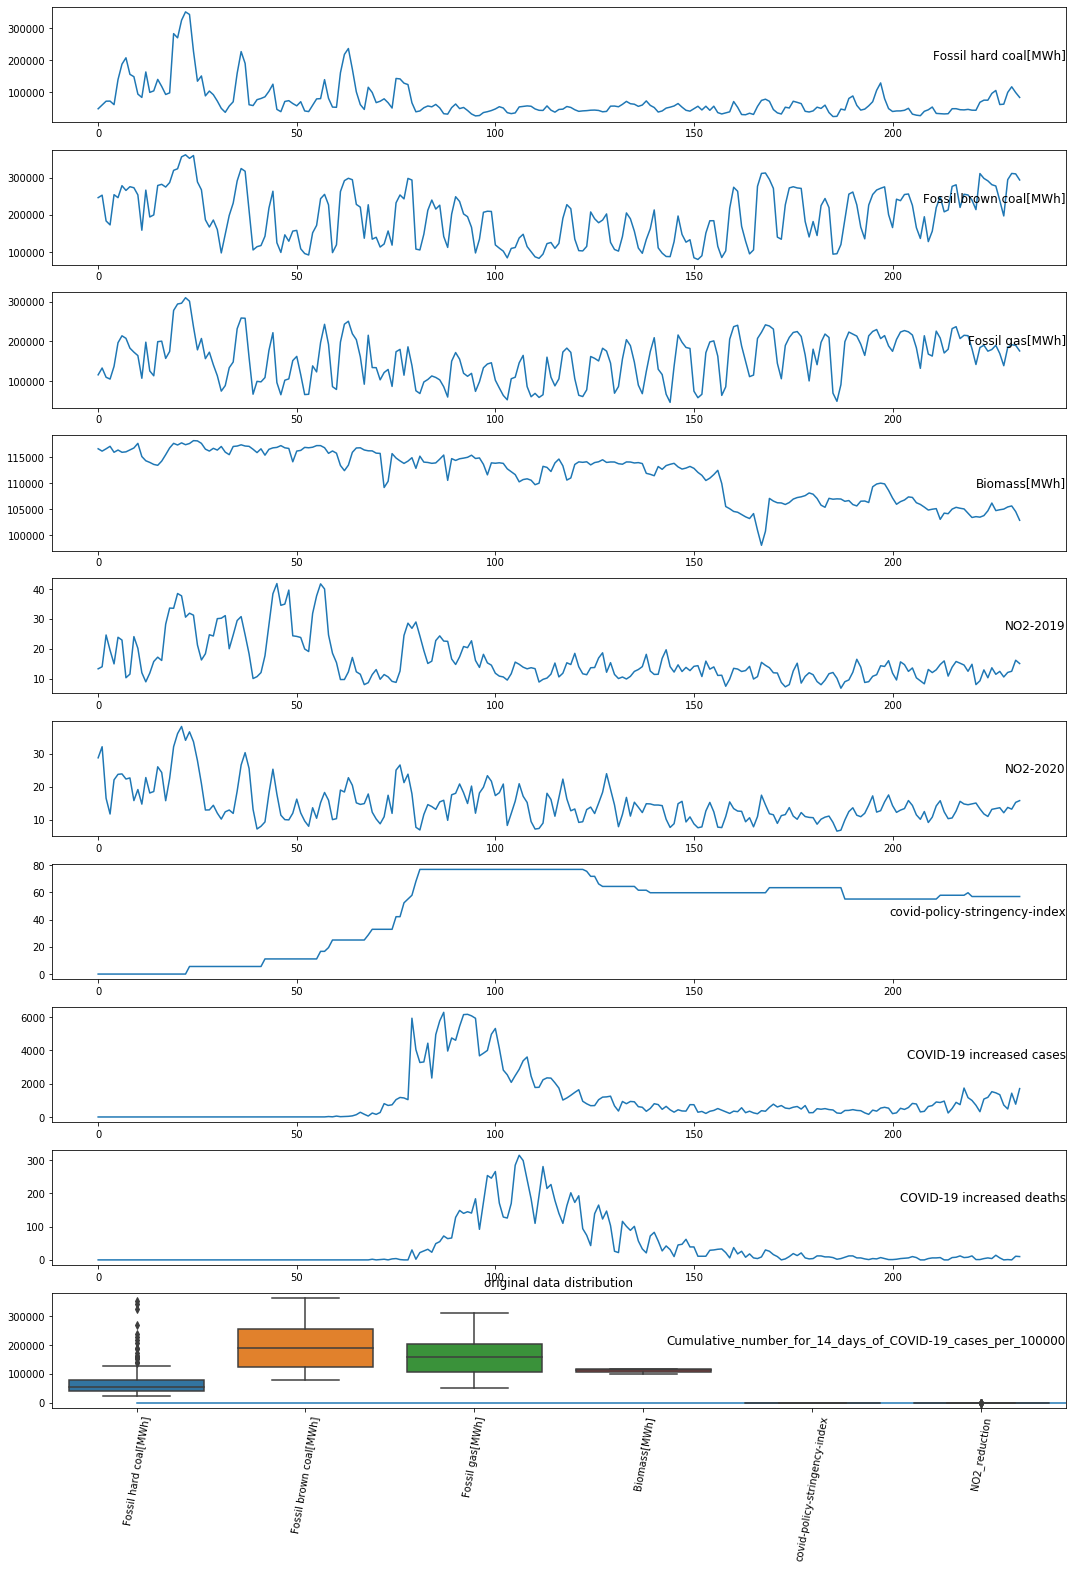

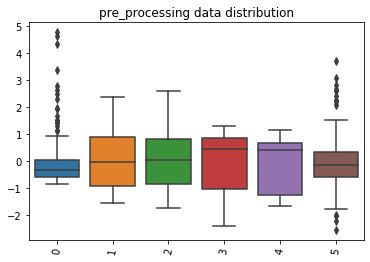

RMSE training fit: 0.000
R2 training fit: 1.000 
RMSE prediction: 0.085
R2 prediction: 0.992 


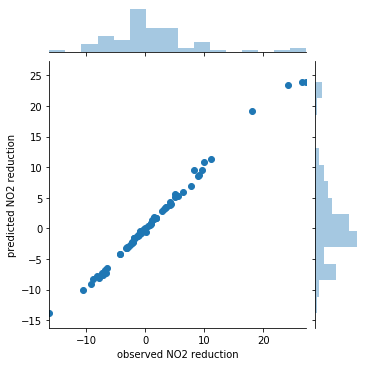

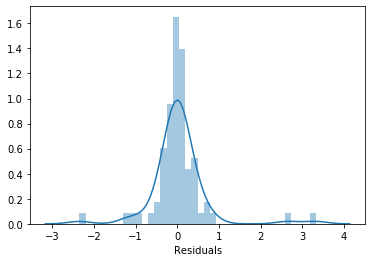

2.5016138553619385


In [77]:
dataset_name = 'AMI_Data.csv'
model_name = 'GBDT'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

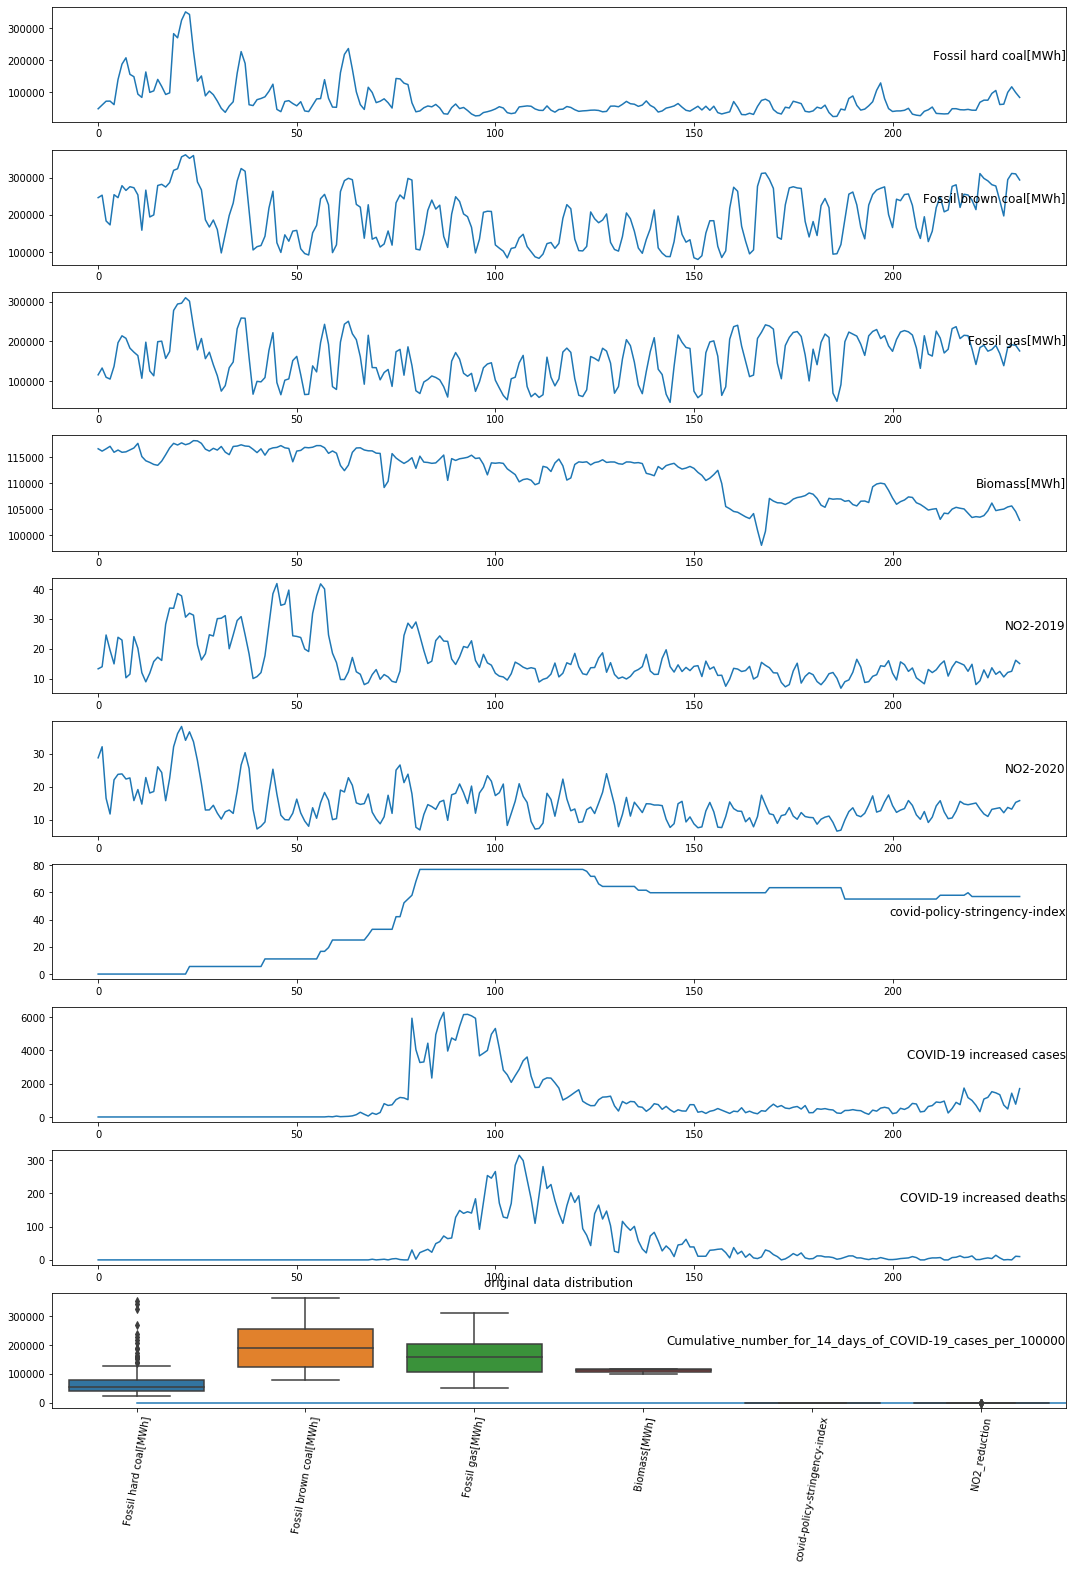

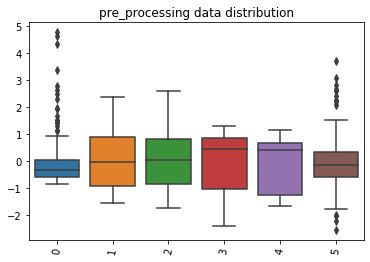

RMSE training fit: 0.386
R2 training fit: 0.851 
RMSE prediction: 0.397
R2 prediction: 0.833 


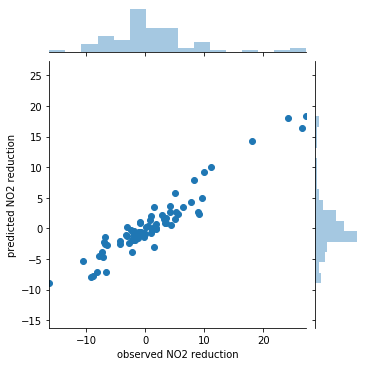

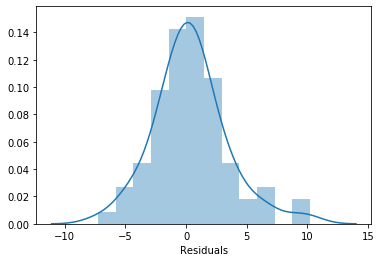

1.6812880039215088


In [78]:
dataset_name = 'AMI_Data.csv'
model_name = 'KNN'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

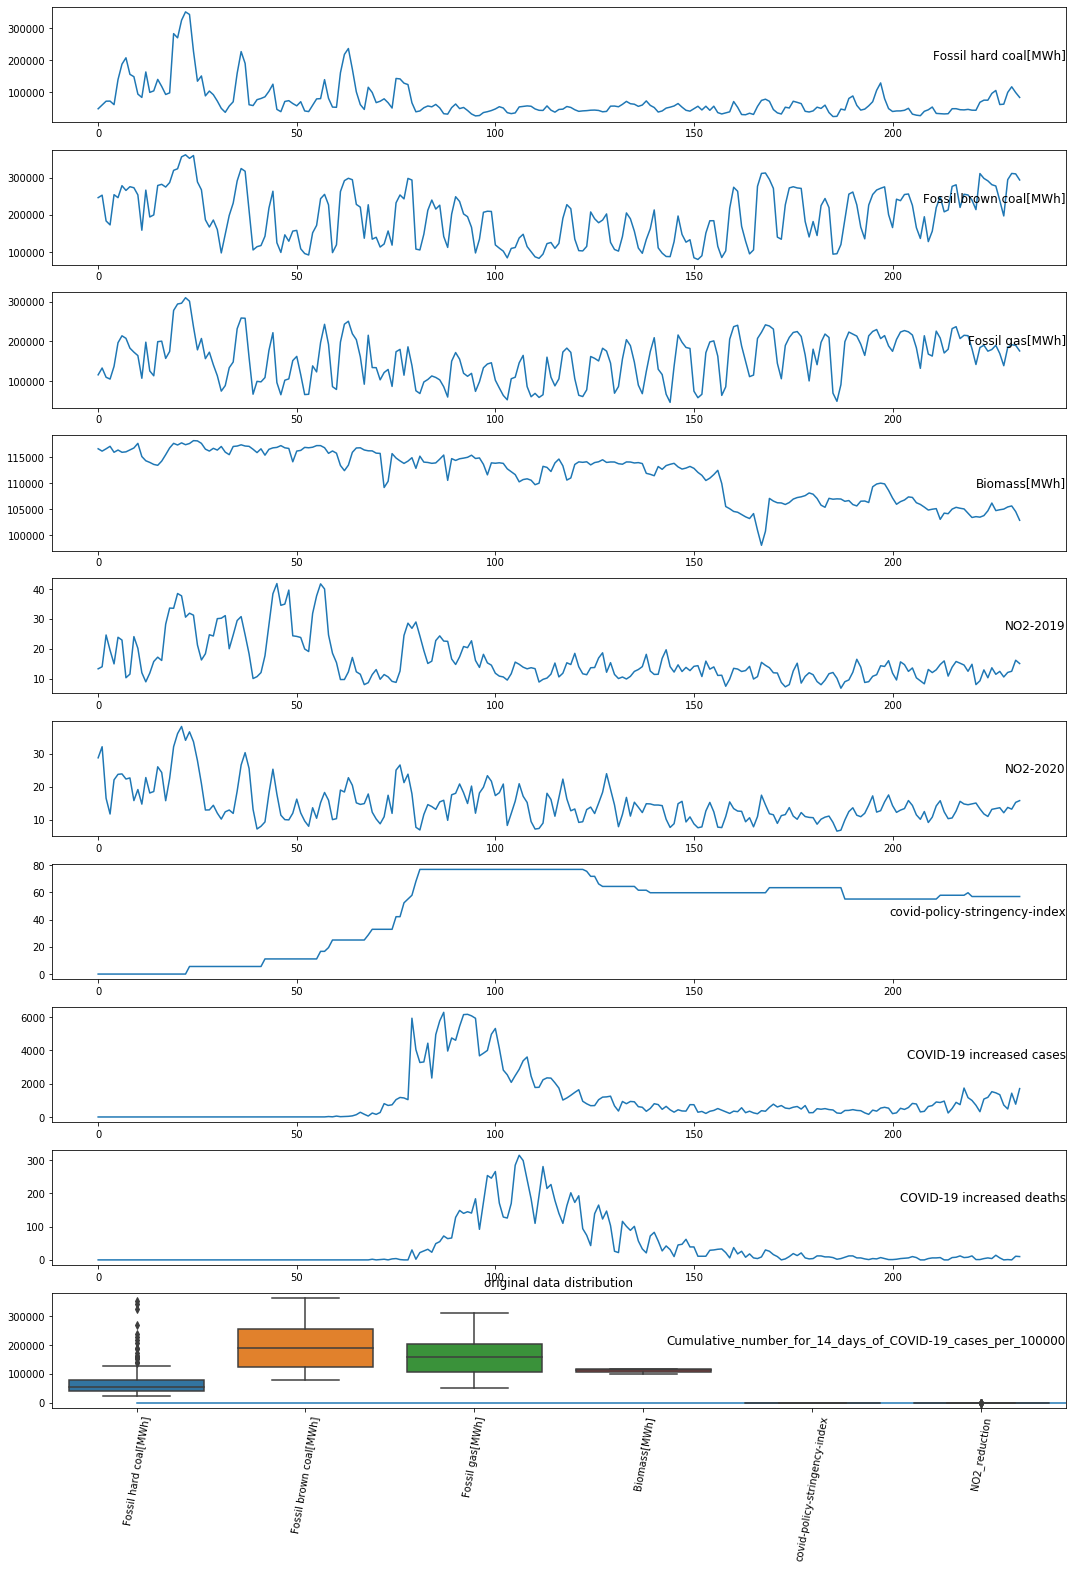

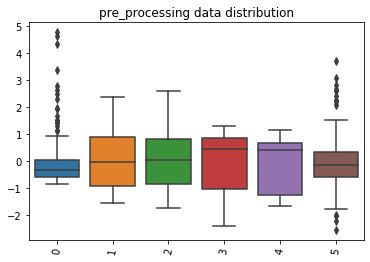

RMSE training fit: 0.441
R2 training fit: 0.805 
RMSE prediction: 0.450
R2 prediction: 0.786 


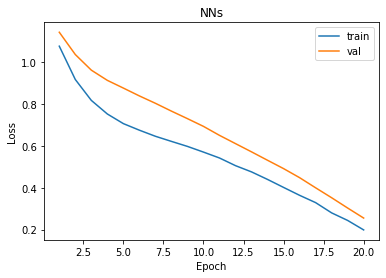

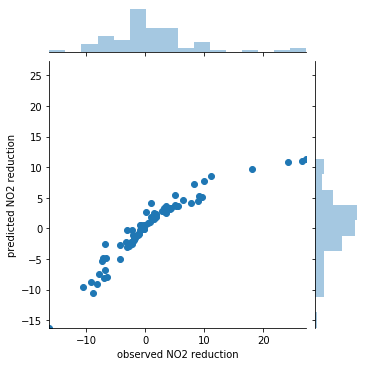

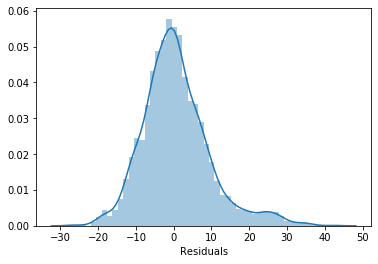

3.8749961853027344


In [83]:
dataset_name = 'AMI_Data.csv'
model_name = 'Neural Network'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

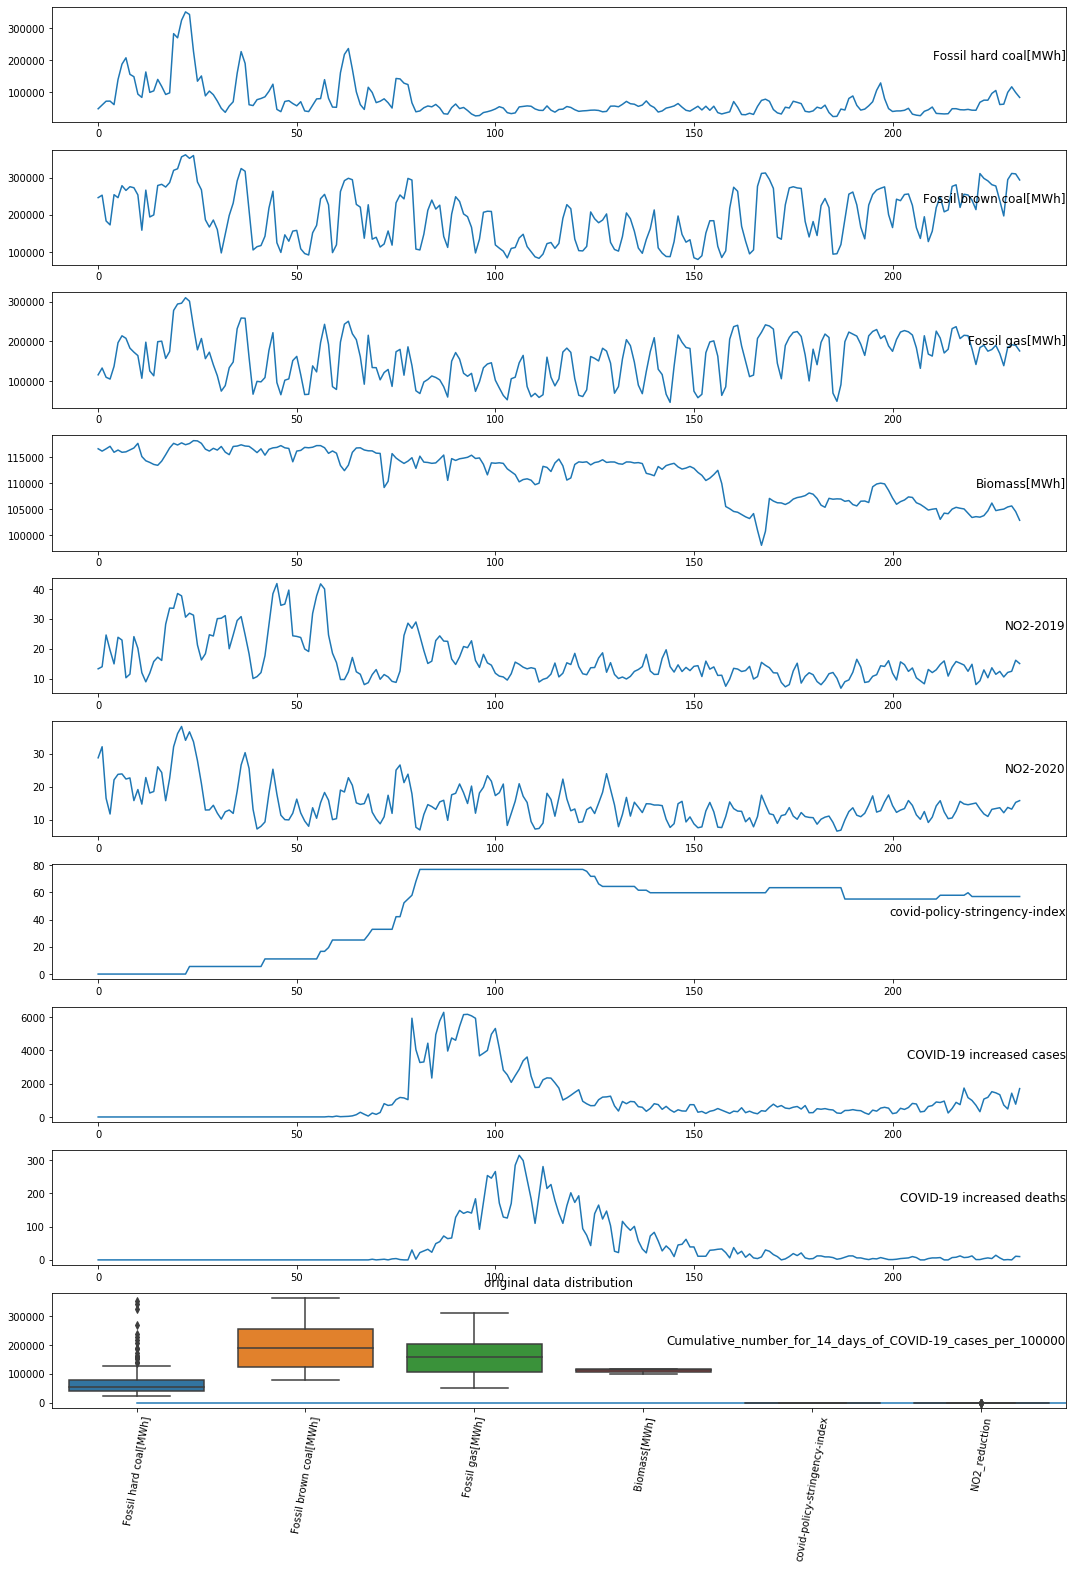

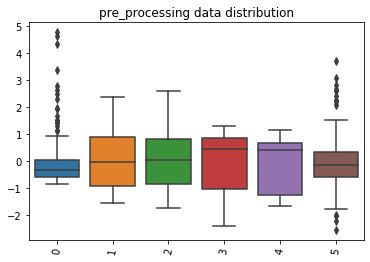

RMSE training fit: 0.000
R2 training fit: 1.000 
RMSE prediction: 0.000
R2 prediction: 1.000 


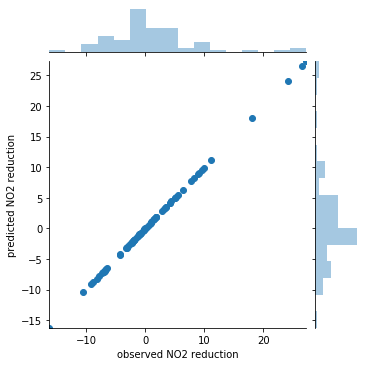

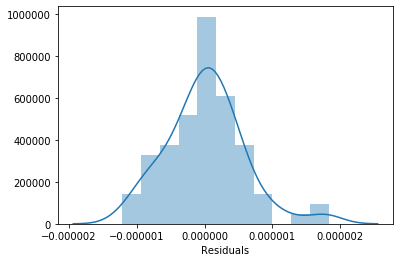

1.3606371879577637


In [84]:
dataset_name = 'AMI_Data.csv'
model_name = 'Gaussian Process'
main(dataset_name,model_name)